<a href="https://colab.research.google.com/github/kaspergroenbek98/first-first-year-project/blob/master/project1notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
nltk.download('stopwords')

fatal: destination path 'first-first-year-project' already exists and is not an empty directory.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, featureData, vocabType): #featureData = data.gender
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = nltk.FreqDist(featureData).most_common(5)
    major_masks = [featureData == f for (f, cnt) in major_features]
    fqs = [nltk.FreqDist(word for line in data.text[mask] for word in line.split()) for mask in major_masks]
    return list(vocabType(data, featureData, major_features, major_masks, fqs, size))

def vocab_most_common(data, featureData, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(np.array(major_masks).sum(axis=0), dtype='bool')
    fq = nltk.FreqDist(word for line in data.text[major_mask] for word in line.split()) # Get a fq for ALL words in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary

### END OF VOCABULARY ###

def cleaner(text):
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    text = text.lower() #All lowercase
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub('https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('b4', 'before', text)
    text = text.strip(' ')
    text = ''.join(char for char in text if char.isalpha() or char == ' ')
    text = ''.join(stemmer.stem(text)) #Stem the words using SnowballStemmer
    return text

In [52]:
"""
Using pandas to load the data file into a CSV.
ISO-8859-1 is the encoding for tweets.
"""
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)
for i in range(len(data.text)): #Cleaning all the text in our data with our newly build cleaner() function.
  data.text[i] = cleaner(data.text[i])

data.text[1]

'newyearsresolution finally master part of kitchen sink'

In [55]:
# Vectorize using sklearn based on a vocabulary
featureData = data.Resolution_Category ### CHANGE FEATURE HERE ###
vectorizer = CountVectorizer(analyzer="word", stop_words= "english", min_df = 20, binary= True, ngram_range = (1,2), vocabulary = generate_vocabulary(data, featureData, vocab_unique))
categories = list(zip(*nltk.FreqDist(featureData).most_common(5)))[0]
mask = np.sum([featureData == category for category in categories], axis = 0, dtype='bool')

# This is required to fix bugs. KFold uses indeces in the length of the array, but pandas "hides" arrays instead of removing them. Reset_index fixes this
featureData = featureData[mask].reset_index()
featureData.drop(["index"], axis = 1)
featureData = featureData.Resolution_Category ### CHANGE FEATURE HERE ###

#Here we use term frequency to downscale the importance of words occuring many times in a tweet. That way we hopefully get more weighted words. 
tfidf_transformer = TfidfTransformer()
features = vectorizer.fit_transform(data.text[mask])
tfidf_features = tfidf_transformer.fit_transform(features)



from sklearn.model_selection import KFold
# Store an object of the KFold class in a variable with shuffle=True
k= 10
kf = KFold(n_splits=k, shuffle=True)
# """ 
# Loop for the models and their designated folds (1 to k)
# and calculate the average of each of the 'k' models' accuracy
# using the NB classifier and k-fold model class.
# """
count = 0 # sum to calculate average of model accuracies
bigram_count = 0 # sum to calculate average of bigram model accuracies
for i, (train, test) in enumerate(kf.split(features)): # Loop over K chunk of data splits
    #Accuracy using term frequency. (Odd that its lower, but we do have a small data set)
    NBmodel = MultinomialNB().fit(tfidf_features[train], featureData[train])
    predicted = NBmodel.predict(tfidf_features[test])
    accuracy = np.mean(predicted == featureData[test])
    count += accuracy

    # A classification_report
    print("Iteration no.", i, "\n")
    print("Accuracy of iteration number", i, ":", accuracy)
    print("Report based on unigrams and bigrams.")
    print(metrics.classification_report(featureData[test], predicted))
    print("\n\n")

average = count/k

print("The accuracy average of the K-fold model: ", average)


Iteration no. 0 

Accuracy of iteration number 0 : 0.5168539325842697
Report based on unigrams and bigrams.
                              precision    recall  f1-score   support

Family/Friends/Relationships       1.00      0.02      0.05        42
            Health & Fitness       0.73      0.59      0.65        81
                       Humor       0.30      0.18      0.22        85
             Personal Growth       0.51      0.84      0.63       192
        Recreation & Leisure       0.50      0.09      0.15        45

                    accuracy                           0.52       445
                   macro avg       0.61      0.35      0.34       445
                weighted avg       0.55      0.52      0.45       445




Iteration no. 1 

Accuracy of iteration number 1 : 0.5573033707865168
Report based on unigrams and bigrams.
                              precision    recall  f1-score   support

Family/Friends/Relationships       0.50      0.03      0.06        31
       

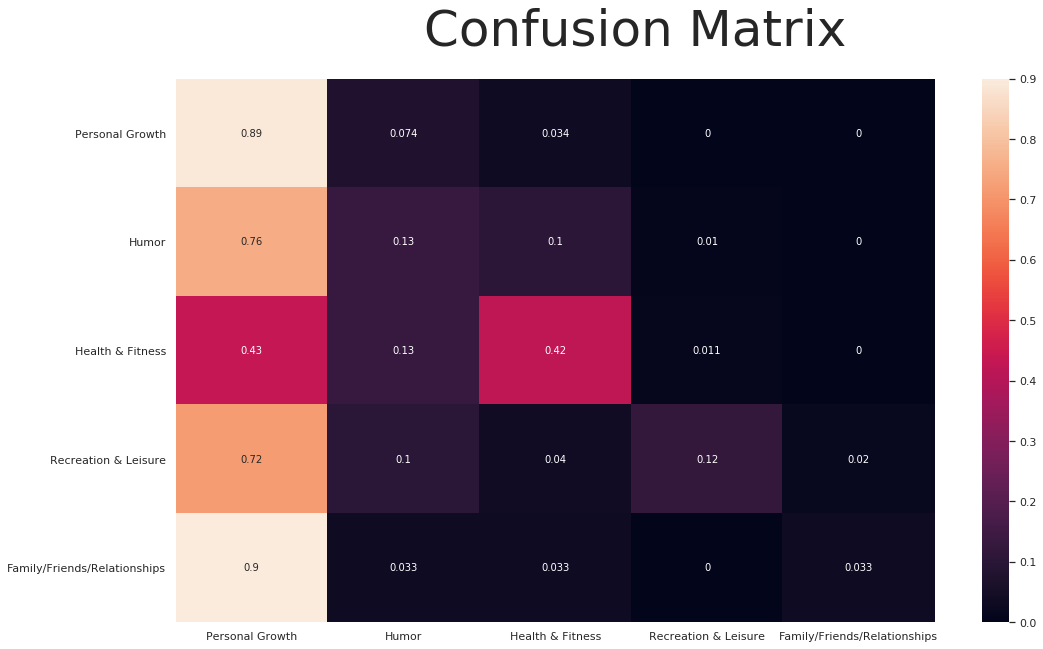

In [80]:
# A perfect confusion matrix using seaborn.
array = metrics.confusion_matrix(featureData[test], predicted, normalize='true', labels = categories)
fig = plt.figure(figsize=(17,10))
fig.suptitle("Confusion Matrix", fontsize= 50)
sn.set(font_scale=1) # for x/y label size
sn.heatmap(array, annot=True, annot_kws={"size": 10}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()

In [81]:
def print_top10(vectorizer, NBmodel): # Found on stackoverflow
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(NBmodel.classes_):
        top10 = np.argsort(NBmodel.coef_[i])[-13:-3]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(vectorizer, NBmodel)

Family/Friends/Relationships: time friend make year family friends rt people resolution years
Health & Fitness: weight drink smoking year stop gym rt eat years resolution
Humor: just like people ûï make stop year rt years resolution
Personal Growth: people better amp make life stop year rt years resolution
Recreation & Leisure: travel going meet play read watch rt year years resolution
